In [1]:
import sys
#!{sys.executable} -m pip install sklearn
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib
import random
import os
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import spatial
from IPython.display import HTML
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel)

import importlib
import scripts.theodolite_function as tfu
import scripts.theodolite_utils as tfuu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.gp_prediction_utils as GPf
GPf = importlib.reload(GPf)
import GPy

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
# Switch values if necessary 1 11 2021
#Dist_prism_12 = 1.0398341231585624*1000
#Dist_prism_13 = 0.818424700118086*1000
#Dist_prism_23 = 0.8806156053859284*1000
#Dist_GPS_12 = 0.835637436093363*1000
#Dist_GPS_13 = 0.7812173648662254*1000
#Dist_GPS_23 = 0.5166745729506486*1000

# 26 11 2021
#Dist_prism_12 = 1.03688797895733
#Dist_prism_13 = 0.822536135483593
#Dist_prism_23 = 0.8783765747673403
#Dist_GPS_12 = 0.7828618536473139
#Dist_GPS_13 = 0.8394208131018045
#Dist_GPS_23 = 0.5176447366930409

# 31 01 2022
#Dist_prism_12 = 1.038854051807371
#Dist_prism_13 = 0.8202157646292075
#Dist_prism_23 = 0.879788333022114
#Dist_GPS_12 = 0.7830826912858335
#Dist_GPS_13 = 0.8418404054627937
#Dist_GPS_23 = 0.5172558618541933
     
# 03 02 2022
#Dist_prism_12 = 1.0403741344089559
#Dist_prism_13 = 0.8239475424257701
#Dist_prism_23 = 0.8766711748547112
#Dist_GPS_12 = 0.781661929058067
#Dist_GPS_13 = 0.8353981332464246
#Dist_GPS_23 = 0.5174987476948135

# 17 02 2022 / 24 02 2022
Dist_prism_12_240222 = 0.8882613537922258
Dist_prism_13_240222 = 0.8262903370535766
Dist_prism_23_240222 = 1.0377436460567973
Dist_GPS_12_240222 = 0.7809786915630756
Dist_GPS_13_240222 = 0.8378323585433202
Dist_GPS_23_240222 = 0.5191788936274444   

# 07 03 2022
Dist_prism_12_070322 = 0.8832836583456264
Dist_prism_13_070322 = 0.8247449387008166
Dist_prism_23_070322 = 1.039409793600046
Dist_GPS_12_070322 = 0.7781099344563802
Dist_GPS_13_070322 = 0.8431026980109139
Dist_GPS_23_070322 = 0.5157221841320069

# 12 03 2022
Dist_prism_12_120322 = 0.8860734460339026
Dist_prism_13_120322 = 0.8303896290142598
Dist_prism_23_120322 = 1.0393117663247973
Dist_GPS_12_120322 = 0.7829424296161074
Dist_GPS_13_120322 = 0.8415176433032493
Dist_GPS_23_120322 = 0.5161917038941966

# 14 03 2022 / 16 03 2022
Dist_prism_12_140322 = 0.8873171656784946
Dist_prism_13_140322 = 0.8272212117473343
Dist_prism_23_140322 = 1.0379270641796363
Dist_GPS_12_140322 = 0.7829081036179948
Dist_GPS_13_140322 = 0.8424633975958637
Dist_GPS_23_140322 = 0.5165807364575292

# 31 03 2022
Dist_prism_12_310322 = 0.8873171656784946
Dist_prism_13_310322 = 0.8272212117473343
Dist_prism_23_310322 = 1.0379270641796363
Dist_GPS_12_310322 = 0.7829081036179948
Dist_GPS_13_310322 = 0.8424633975958637
Dist_GPS_23_310322 = 0.5165807364575292

Inter_distance = [[Dist_prism_12_240222,Dist_prism_13_240222,Dist_prism_23_240222,Dist_GPS_12_240222,Dist_GPS_13_240222,Dist_GPS_23_240222],
                 [Dist_prism_12_070322,Dist_prism_13_070322,Dist_prism_23_070322,Dist_GPS_12_070322,Dist_GPS_13_070322,Dist_GPS_23_070322],
                 [Dist_prism_12_120322,Dist_prism_13_120322,Dist_prism_23_120322,Dist_GPS_12_120322,Dist_GPS_13_120322,Dist_GPS_23_120322],
                 [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
                 [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
                 [Dist_prism_12_310322,Dist_prism_13_310322,Dist_prism_23_310322,Dist_GPS_12_310322,Dist_GPS_13_310322,Dist_GPS_23_310322],]


In [3]:
# Read rosbag of grand axe and show the trajectory
ttfu = importlib.reload(tfuu)

#file_name = './data/total_station/20220224/20220224_theodolite_reference_prisms.txt'
#file_name = './data/total_station/20220307/theodolite_reference_prisms.txt'
file_name = './data/total_station/20220312/theodolite_reference_prisms.txt'
#file_name = './data/total_station/20220314/theodolite_reference_prisms.txt'
#file_name = './data/total_station/20220316/theodolite_reference_prisms.txt'
#file_name = './data/total_station/20220331-1/theodolite_reference_prisms.txt'
#file_name = './data/total_station/20220331-2/theodolite_reference_prisms.txt'

trimble_1, trimble_2, trimble_3, T_1_grand, T_2_grand, T_3_grand = tfu.read_marker_file(file_name, 1)

#file = "/home/norlab/Data/IROS_2022/20220224_TS/2022-02-24-15-34-38.bag"
#file = "/home/norlab/Data/IROS_2022/20220307_TS/2022-03-07-19-20-06.bag"
file = "/home/norlab/Data/IROS_2022/20220312_TS/2022-03-12-09-45-12.bag"
#file = "/home/norlab/Data/IROS_2022/20220314_TS/2022-03-14-10-47-49.bag"
#file = "/home/norlab/Data/IROS_2022/20220316_TS/2022-03-16-19-02-42.bag"
#file = "/home/norlab/Data/IROS_2022/20220331_TS/2022-03-31-10-22-52.bag"  # Tree experiments
#file = "/home/norlab/Data/IROS_2022/20220331_TS/2022-03-31-11-20-05.bag"

time_trimble_1, time_trimble_2, time_trimble_3, distance_1, distance_2, distance_3, azimuth_1, azimuth_2, azimuth_3, elevation_1, elevation_2, elevation_3 = ttfu.read_rosbag_theodolite_with_tf_raw_data(file)

Number of data for theodolites: [7785 7893 8312]
Bad measures: 658


In [4]:
tfuu = importlib.reload(tfuu)
path = "./data/prediction/TS/20220312/"
index_prism = 2
prefix = "GP-10-20"
P1 = np.array(tfuu.read_prediction_data_csv_file(path+prefix +"_1.csv"))
P2 = np.array(tfuu.read_prediction_data_csv_file(path+prefix +"_2.csv"))
P3 = np.array(tfuu.read_prediction_data_csv_file(path+prefix +"_3.csv"))

dist_prism = []
origin = 0
#origin = min(P1[0,0],P2[0,0],P3[0,0])
for i in range(0,len(P1[:,0])):
    dp1 = abs(np.linalg.norm(P1[i,1:4]-P2[i,1:4])-Inter_distance[index_prism][0])*1000
    dp2 = abs(np.linalg.norm(P1[i,1:4]-P3[i,1:4])-Inter_distance[index_prism][1])*1000
    dp3 = abs(np.linalg.norm(P3[i,1:4]-P2[i,1:4])-Inter_distance[index_prism][2])*1000
    dist_prism.append(np.array([P1[i,0]-origin, dp1, dp2, dp3]))
dist_prism = np.array(dist_prism)

In [23]:
dist_prism_arr = np.array(dist_prism)
err_distance_1 = []
err_distance_2 = []
err_distance_3 = []
err_azimuth_1 = []
err_azimuth_2 = []
err_azimuth_3 = []
err_elevation_1 = []
err_elevation_2 = []
err_elevation_3 = []
for i,j,k,l in zip(time_trimble_1, distance_1, azimuth_1, elevation_1):
    ind1, t1 = tfu.findClosest(dist_prism_arr[:,0], i)
    err_distance_1.append(np.array([i, j, dist_prism_arr[ind1,1]]))
    err_azimuth_1.append(np.array([i, k, dist_prism_arr[ind1,1]]))
    err_elevation_1.append(np.array([i, l, dist_prism_arr[ind1,1]]))
    
for i,j,k,l in zip(time_trimble_2, distance_2, azimuth_2, elevation_2):
    ind2, t2 = tfu.findClosest(dist_prism_arr[:,0], i)
    err_distance_2.append(np.array([i, j, dist_prism_arr[ind2,2]]))
    err_azimuth_2.append(np.array([i, k, dist_prism_arr[ind2,2]]))
    err_elevation_2.append(np.array([i, l, dist_prism_arr[ind2,2]]))
    
for i,j,k,l in zip(time_trimble_3, distance_3, azimuth_3, elevation_3):
    ind3, t3 = tfu.findClosest(dist_prism_arr[:,0], i)
    err_distance_3.append(np.array([i, j, dist_prism_arr[ind3,3]]))
    err_azimuth_3.append(np.array([i, k, dist_prism_arr[ind3,3]]))
    err_elevation_3.append(np.array([i, l, dist_prism_arr[ind3,3]]))

<IPython.core.display.Javascript object>


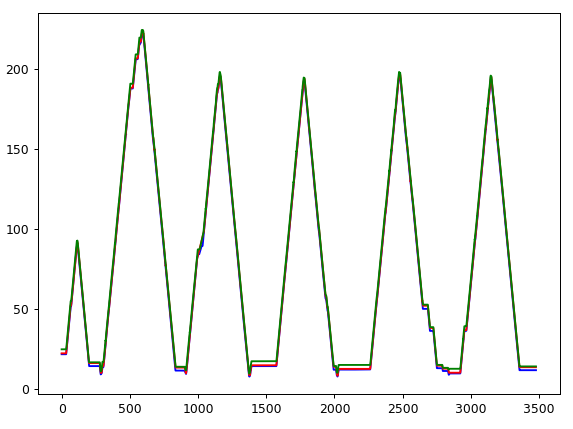

<IPython.core.display.Javascript object>


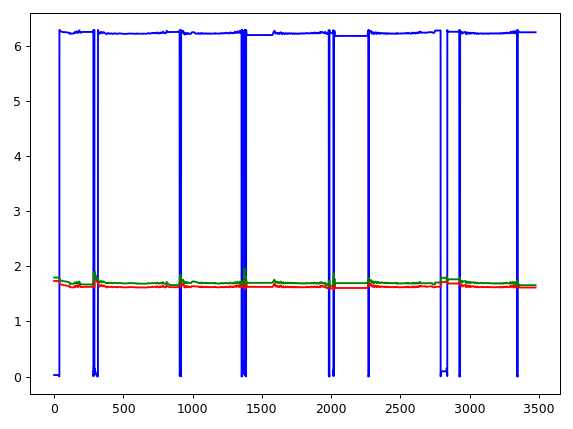

<IPython.core.display.Javascript object>


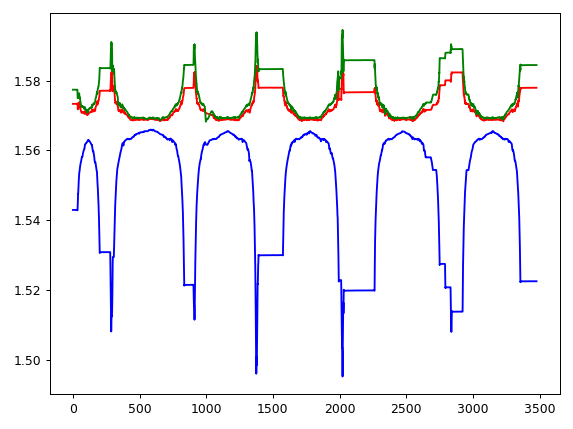

In [11]:
%matplotlib notebook
offset_timestamp = min(time_trimble_1[0],time_trimble_2[0],time_trimble_1[2])
plt.figure(0)
plt.plot([(i-offset_timestamp) for i in time_trimble_1], distance_1, color='b')
plt.plot([(i-offset_timestamp) for i in time_trimble_2], distance_2, color='r')
plt.plot([(i-offset_timestamp) for i in time_trimble_3], distance_3, color='g')
plt.figure(1)
plt.plot([(i-offset_timestamp) for i in time_trimble_1], azimuth_1, color='b')
plt.plot([(i-offset_timestamp) for i in time_trimble_2], azimuth_2, color='r')
plt.plot([(i-offset_timestamp) for i in time_trimble_3], azimuth_3, color='g')
plt.figure(2)
plt.plot([(i-offset_timestamp) for i in time_trimble_1], elevation_1, color='b')
plt.plot([(i-offset_timestamp) for i in time_trimble_2], elevation_2, color='r')
plt.plot([(i-offset_timestamp) for i in time_trimble_3], elevation_3, color='g')

<IPython.core.display.Javascript object>


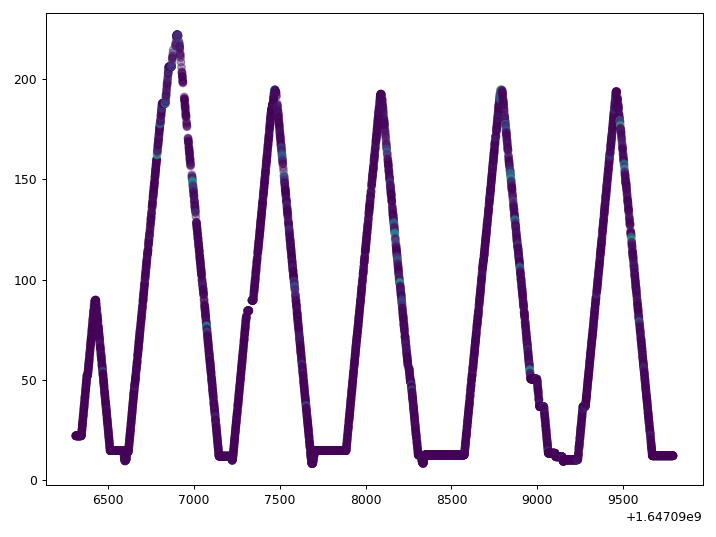

ValueError: 'c' argument has 7893 elements, which is inconsistent with 'x' and 'y' with size 7785.

In [31]:
%matplotlib notebook

err_distance_1 = np.array(err_distance_1)
err_distance_2 = np.array(err_distance_2)
err_distance_3 = np.array(err_distance_3)
err_azimuth_1 = np.array(err_azimuth_1)
err_azimuth_2 = np.array(err_azimuth_2)
err_azimuth_3 = np.array(err_azimuth_3)
err_elevation_1 = np.array(err_elevation_1)
err_elevation_2 = np.array(err_elevation_2)
err_elevation_3 = np.array(err_elevation_3)

fig, ax = plt.subplots(nrows=1, figsize=(8,6))
sc=ax.scatter(err_distance_1[:,0], err_distance_1[:,1], c=err_distance_1[:,2], cmap='viridis', alpha=0.4)
sc=ax.scatter(err_distance_1[:,0], err_distance_1[:,1], c=err_distance_2[:,2], cmap='viridis', alpha=0.4)
plt.colorbar(sc, label="Inter-prism error [m]")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Distance [m]")
fig.tight_layout()

<IPython.core.display.Javascript object>


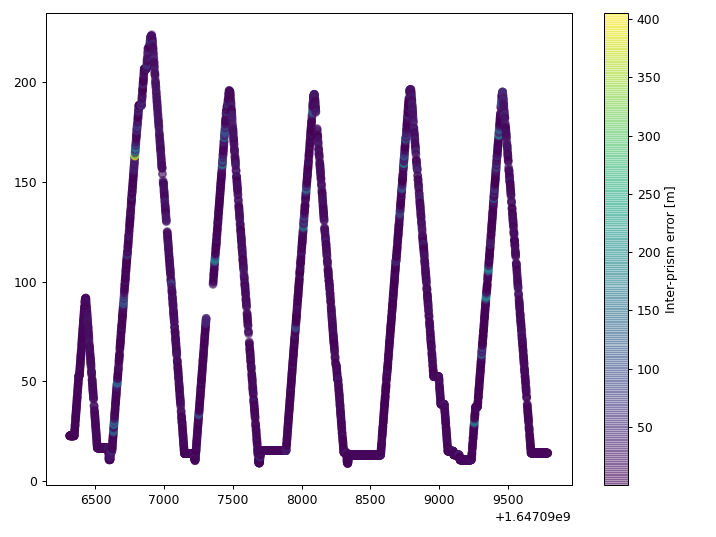

In [26]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
sc=ax.scatter(err_distance_2[:,0], err_distance_2[:,1], c=err_distance_2[:,2], cmap='viridis', alpha=0.4)
plt.colorbar(sc, label="Inter-prism error [m]")
fig.tight_layout()

<IPython.core.display.Javascript object>


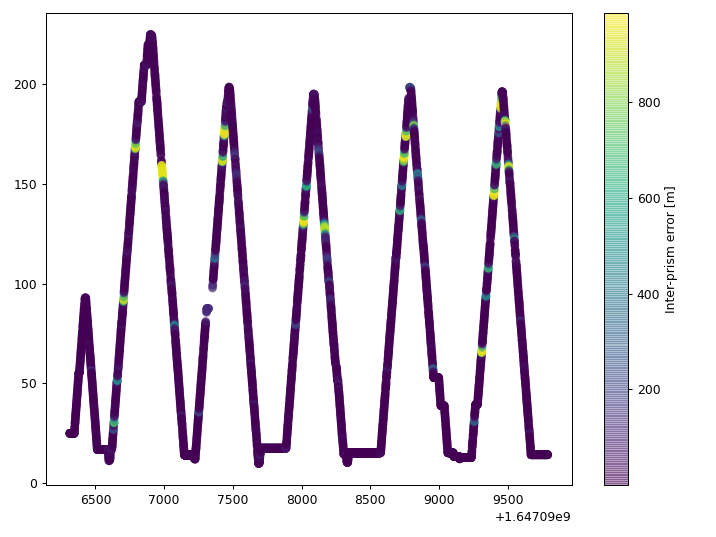

In [27]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
sc=plt.scatter(err_distance_3[:,0], err_distance_3[:,1], c=err_distance_3[:,2], cmap='viridis', alpha=0.4)
plt.colorbar(sc, label="Inter-prism error [m]")
fig.tight_layout()

In [5]:
dist_prism_arr = np.array(dist_prism)
err_distance_12 = []
err_distance_13 = []
err_distance_23 = []
err_azimuth_12 = []
err_azimuth_13 = []
err_azimuth_23 = []
err_elevation_12 = []
err_elevation_13 = []
err_elevation_23 = []

for i in dist_prism_arr:
    ind1, t1 = tfu.findClosest(time_trimble_1, i[0])
    ind2, t2 = tfu.findClosest(time_trimble_2, i[0])
    err_azimuth_12.append(np.array([i[0], azimuth_1[ind1], azimuth_2[ind2], i[1]]))
    err_distance_12.append(np.array([i[0], distance_1[ind1], distance_2[ind2], i[1]]))
    err_elevation_12.append(np.array([i[0], elevation_1[ind1], elevation_2[ind2], i[1]]))
    
for i in dist_prism_arr:
    ind1, t1 = tfu.findClosest(time_trimble_1, i[0])
    ind3, t3 = tfu.findClosest(time_trimble_3, i[0])
    err_azimuth_13.append(np.array([i[0], azimuth_1[ind1], azimuth_3[ind3], i[2]]))
    err_distance_13.append(np.array([i[0], distance_1[ind1], distance_3[ind3], i[2]]))
    err_elevation_13.append(np.array([i[0], elevation_1[ind1], elevation_3[ind3], i[2]]))
    
for i in dist_prism_arr:
    ind2, t2 = tfu.findClosest(time_trimble_2, i[0])
    ind3, t3 = tfu.findClosest(time_trimble_3, i[0])
    err_azimuth_23.append(np.array([i[0], azimuth_2[ind2], azimuth_3[ind3], i[3]]))
    err_distance_23.append(np.array([i[0], distance_2[ind2], distance_3[ind3], i[3]]))
    err_elevation_23.append(np.array([i[0], elevation_2[ind2], elevation_3[ind3], i[3]]))

In [16]:
# Sort data for 2.5D plot
tfu = importlib.reload(tfu)
tfuu = importlib.reload(tfuu)
linear_speed_list = []
angular_speed_list = []
accel_list = []
mean_error_prisms_list = []

list_dataset_GP = ["./data/prediction/TS/20220312/"]

list_calib = ["./data/total_station/20220312/theodolite_reference_prisms.txt"]

list_rosbag = ["/home/norlab/Data/IROS_2022/20220312_TS/2022-03-12-09-45-12.bag"]

speed_l = []
angular_l = []
accel_l = []
error_l = []
for path,file_rosbag_theodolite in zip(list_dataset_GP,list_rosbag):
    linear_speed_list, angular_speed_list, accel_list, mean_error_prisms_list = tfu.process_data_TS(path, Inter_distance[2], file_rosbag_theodolite)
    speed_l = speed_l + linear_speed_list
    angular_l = angular_l + angular_speed_list
    accel_l = accel_l + accel_list
    error_l = error_l + mean_error_prisms_list
    print(len(error_l))

Linear velocity reading
Angular velocity reading


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


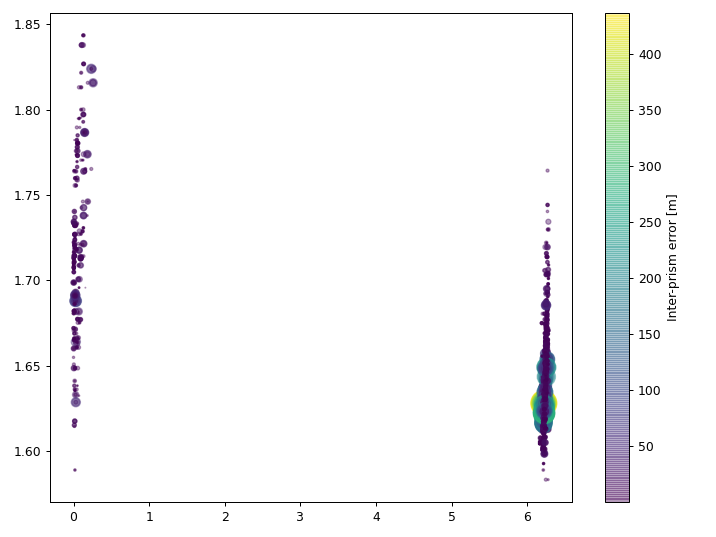

In [10]:
%matplotlib notebook
err_arr = np.array(err_azimuth_12)
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
sc=plt.scatter(err_arr[:,1], err_arr[:,2], s=err_arr[:,3], c=err_arr[:,3], cmap='viridis', alpha=0.4)
plt.colorbar(sc, label="Inter-prism error [m]")
fig.tight_layout()

<IPython.core.display.Javascript object>


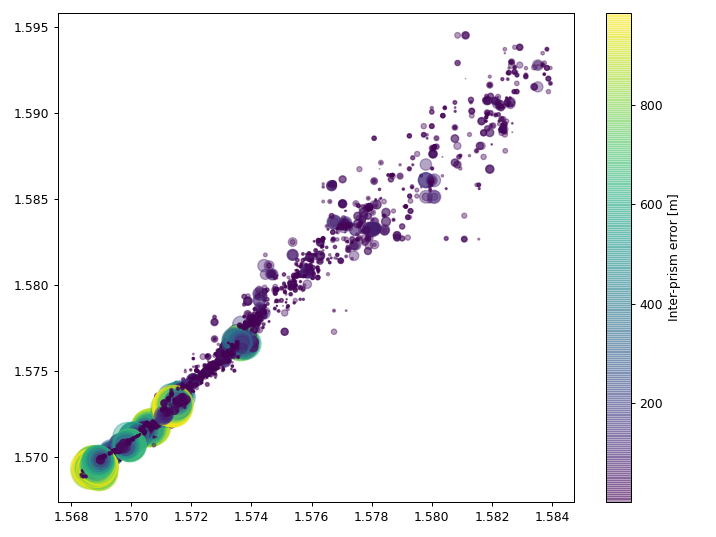

In [11]:
%matplotlib notebook
err_arr = np.array(err_elevation_23)
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
sc=plt.scatter(err_arr[:,1], err_arr[:,2], s=err_arr[:,3], c=err_arr[:,3], cmap='viridis', alpha=0.4)
plt.colorbar(sc, label="Inter-prism error [m]")
fig.tight_layout()

<IPython.core.display.Javascript object>


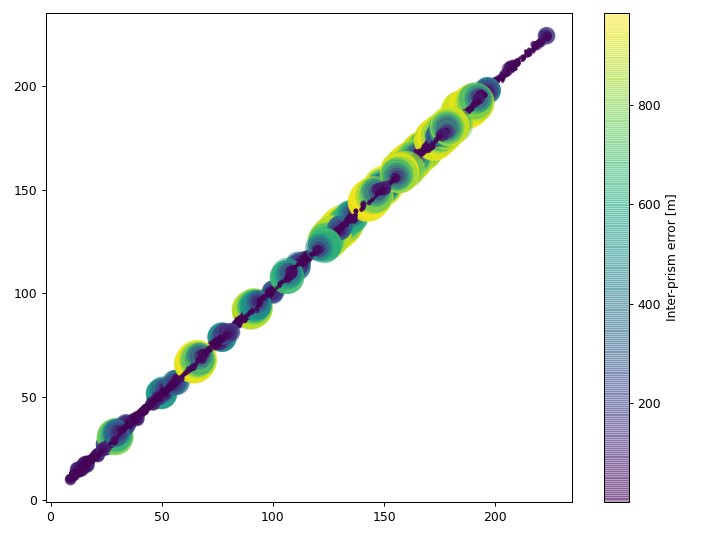

In [12]:
%matplotlib notebook
err_arr = np.array(err_distance_23)
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
sc=plt.scatter(err_arr[:,1], err_arr[:,2], s=err_arr[:,3], c=err_arr[:,3], cmap='viridis', alpha=0.4)
plt.colorbar(sc, label="Inter-prism error [m]")
fig.tight_layout()

<IPython.core.display.Javascript object>


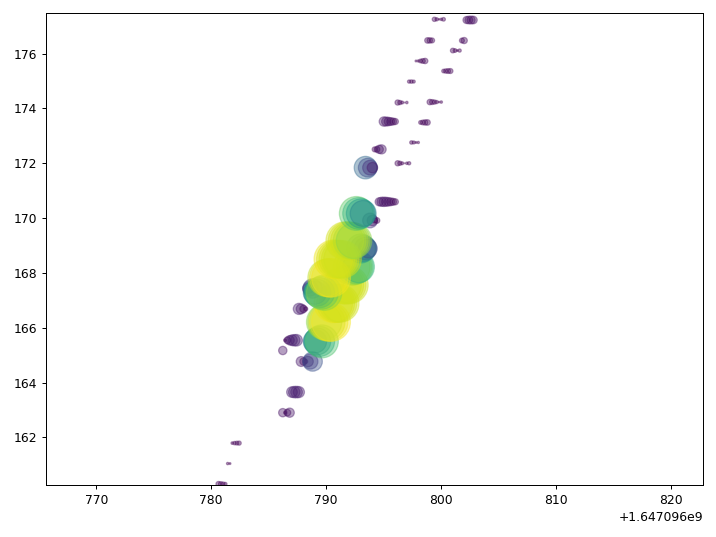

In [26]:
%matplotlib notebook
err_arr = np.array(err_distance_23)
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(err_arr[:,0], err_arr[:,1], s=err_arr[:,3], c=err_arr[:,3], cmap='viridis', alpha=0.4)
ax.scatter(err_arr[:,0], err_arr[:,2], s=err_arr[:,3], c=err_arr[:,3], cmap='viridis', alpha=0.4)
#plt.colorbar(sc, label="Inter-prism error [m]")
fig.tight_layout()

<IPython.core.display.Javascript object>


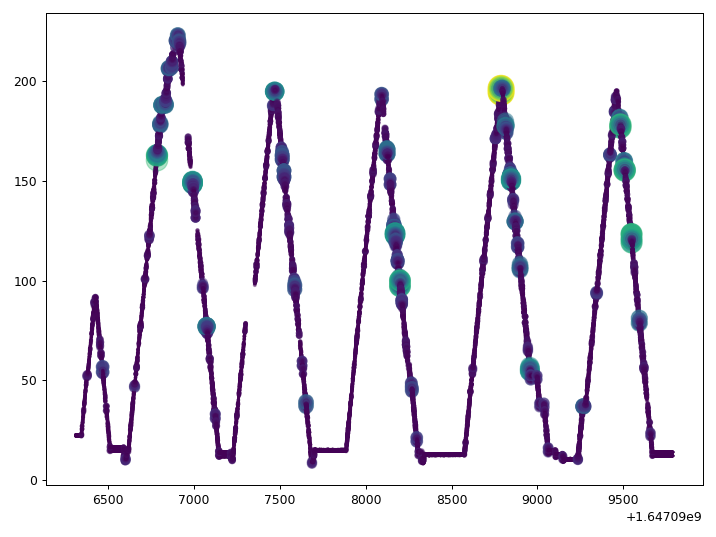

In [83]:
err_arr = np.array(err_distance_12)
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(err_arr[:,0], err_arr[:,1], s=err_arr[:,3], c=err_arr[:,3], cmap='viridis', alpha=0.4)
ax.scatter(err_arr[:,0], err_arr[:,2], s=err_arr[:,3], c=err_arr[:,3], cmap='viridis', alpha=0.4)
#plt.colorbar(sc, label="Inter-prism error [m]")
fig.tight_layout()

<IPython.core.display.Javascript object>


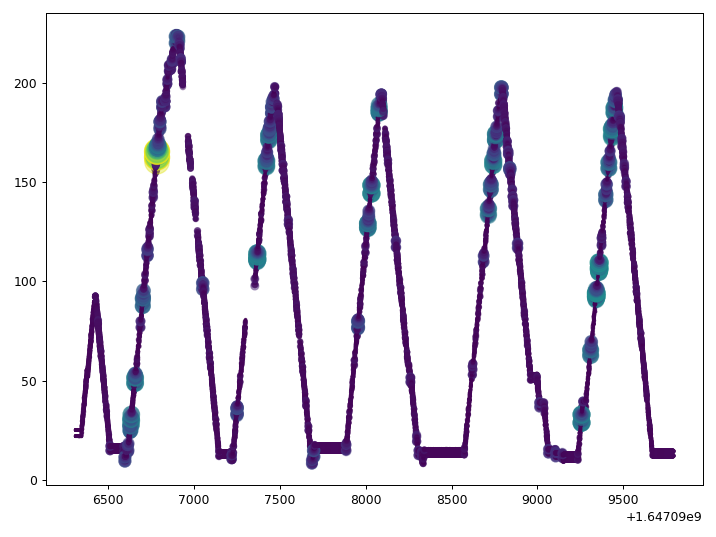

In [84]:
err_arr = np.array(err_distance_13)
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(err_arr[:,0], err_arr[:,1], s=err_arr[:,3], c=err_arr[:,3], cmap='viridis', alpha=0.4)
ax.scatter(err_arr[:,0], err_arr[:,2], s=err_arr[:,3], c=err_arr[:,3], cmap='viridis', alpha=0.4)
#plt.colorbar(sc, label="Inter-prism error [m]")
fig.tight_layout()

<IPython.core.display.Javascript object>


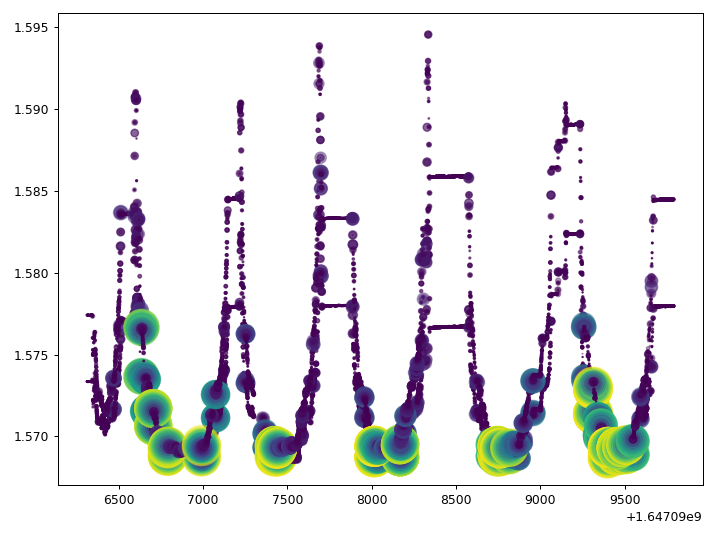

In [85]:
err_arr = np.array(err_elevation_23)
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(err_arr[:,0], err_arr[:,1], s=err_arr[:,3], c=err_arr[:,3], cmap='viridis', alpha=0.4)
ax.scatter(err_arr[:,0], err_arr[:,2], s=err_arr[:,3], c=err_arr[:,3], cmap='viridis', alpha=0.4)
#plt.colorbar(sc, label="Inter-prism error [m]")
fig.tight_layout()

<IPython.core.display.Javascript object>


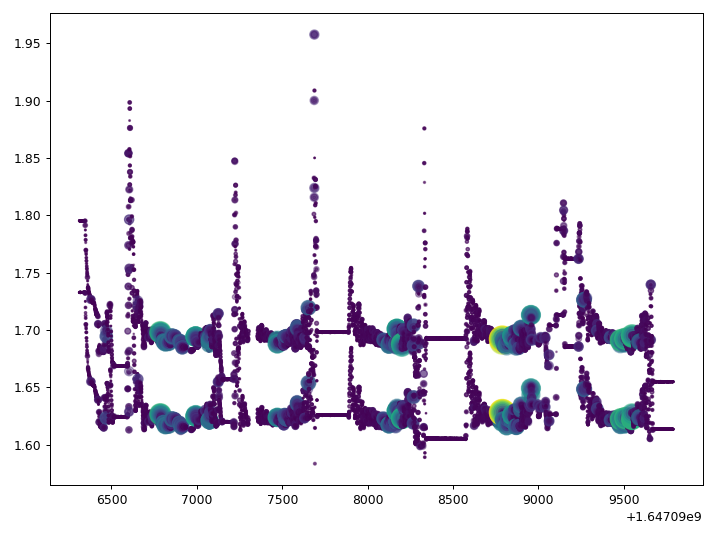

In [75]:
err_arr = np.array(err_azimuth_23)
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(err_arr[:,0], err_arr[:,1], s=err_arr[:,3], c=err_arr[:,3], cmap='viridis', alpha=0.4)
ax.scatter(err_arr[:,0], err_arr[:,2], s=err_arr[:,3], c=err_arr[:,3], cmap='viridis', alpha=0.4)
#plt.colorbar(sc, label="Inter-prism error [m]")
fig.tight_layout()

In [17]:
tfuu = importlib.reload(tfuu)
path = "./data/prediction/TS/20220312/"
index_prism = 2
prefix = "GP-10-20"
P1 = np.array(tfuu.read_prediction_data_csv_file(path+prefix +"_1.csv"))
P2 = np.array(tfuu.read_prediction_data_csv_file(path+prefix +"_2.csv"))
P3 = np.array(tfuu.read_prediction_data_csv_file(path+prefix +"_3.csv"))

path = "./data/total_station/20220312/"

time_trimble_1, trimble_1 = tfuu.read_point_data_csv_file(path+"trimble1.csv")
time_trimble_2, trimble_2 = tfuu.read_point_data_csv_file(path+"trimble2.csv")
time_trimble_3, trimble_3 = tfuu.read_point_data_csv_file(path+"trimble3.csv")



 /home/norlab/Repo_git/code_publication_IROS2022_MaximeVaidis/scripts/theodolite_utils.py:304: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [20]:
print(P1)

[[ 1.64709631e+09  2.19658038e+01 -5.88316835e-01 ...  6.23452206e-06
   1.51515216e-06  5.86443429e-07]
 [ 1.64709631e+09  2.19657935e+01 -5.88322569e-01 ...  1.32347577e-06
   3.37144283e-07  6.16256951e-07]
 [ 1.64709631e+09  2.19658307e+01 -5.88309192e-01 ...  7.68437758e-06
   1.96518897e-06  6.83641677e-07]
 ...
 [ 1.64709979e+09  1.19901767e+01  5.19236054e-01 ...  1.78329062e-05
   1.28328314e-07  4.41065087e-07]
 [ 1.64709979e+09  1.19901938e+01  5.19294318e-01 ...  1.77942976e-05
   3.62506295e-08  4.38415760e-07]
 [ 1.64709979e+09  1.19899904e+01  5.19342463e-01 ...  1.88899003e-05
   3.07998833e-07  4.86043017e-07]]


<IPython.core.display.Javascript object>


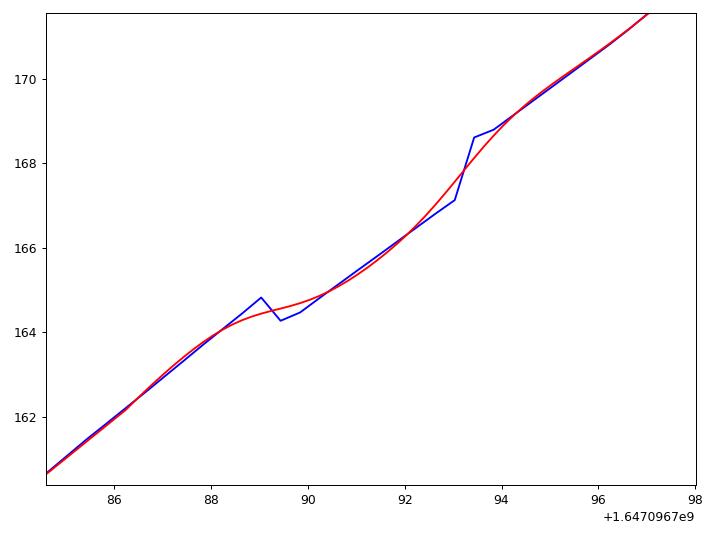

In [25]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.plot(np.array(time_trimble_3), np.array(trimble_3)[0,:], color='b')
ax.plot(np.array(P3)[:,0], np.array(P3)[:,1], color='r')
fig.tight_layout()

<IPython.core.display.Javascript object>


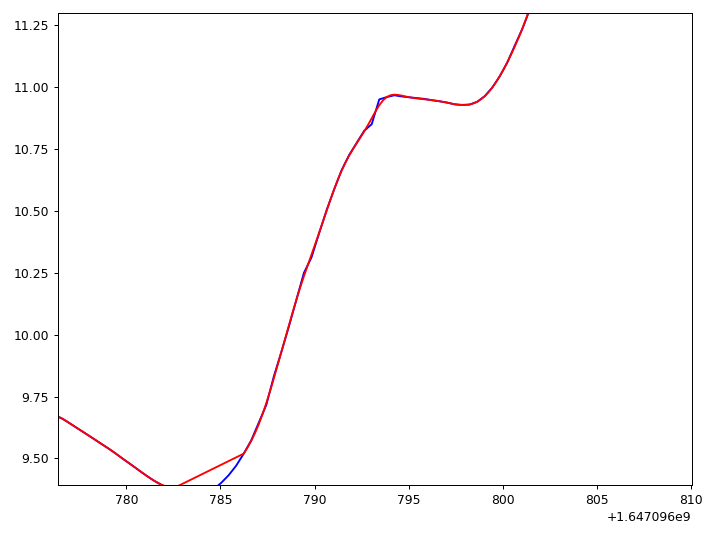

In [30]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.plot(np.array(time_trimble_3), np.array(trimble_3)[1,:], color='b')
ax.plot(np.array(P3)[:,0], np.array(P3)[:,2], color='r')
fig.tight_layout()

<IPython.core.display.Javascript object>


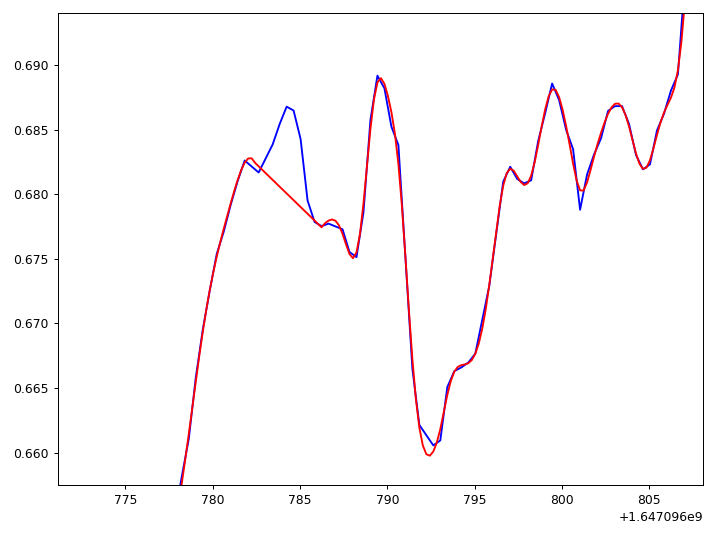

In [34]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.plot(np.array(time_trimble_3), np.array(trimble_3)[2,:], color='b')
ax.plot(np.array(P3)[:,0], np.array(P3)[:,3], color='r')
fig.tight_layout()

<IPython.core.display.Javascript object>


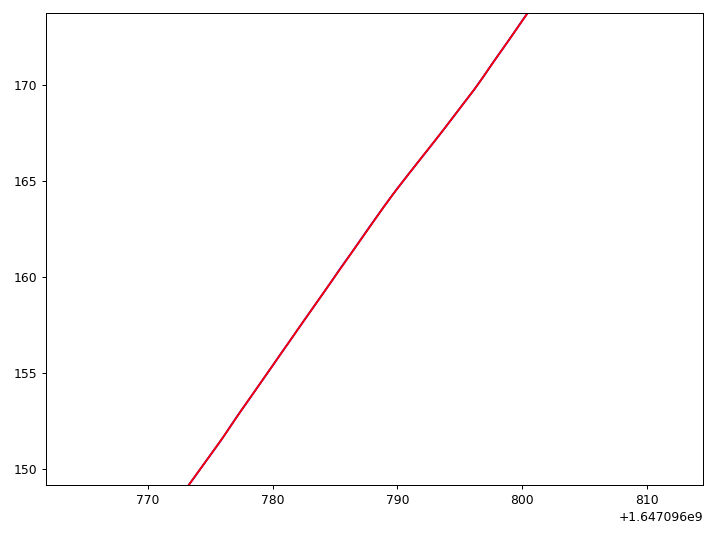

In [31]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.plot(np.array(time_trimble_2), np.array(trimble_2)[0,:], color='b')
ax.plot(np.array(P2)[:,0], np.array(P2)[:,1], color='r')
fig.tight_layout()

<IPython.core.display.Javascript object>


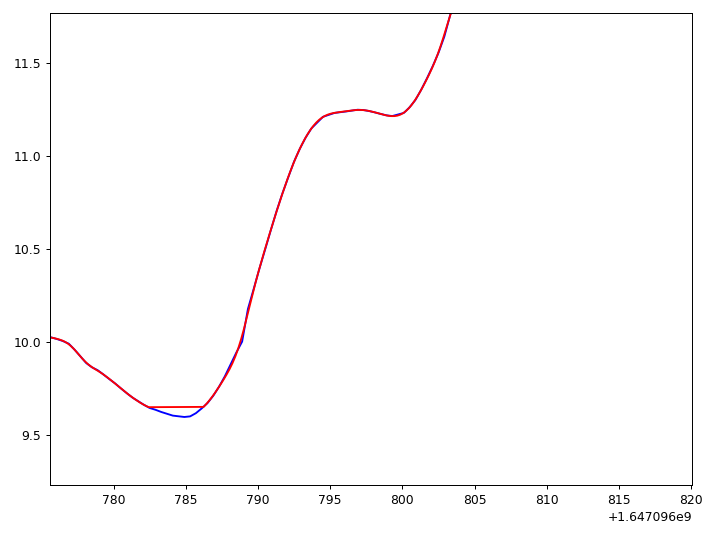

In [32]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.plot(np.array(time_trimble_2), np.array(trimble_2)[1,:], color='b')
ax.plot(np.array(P2)[:,0], np.array(P2)[:,2], color='r')
fig.tight_layout()

<IPython.core.display.Javascript object>


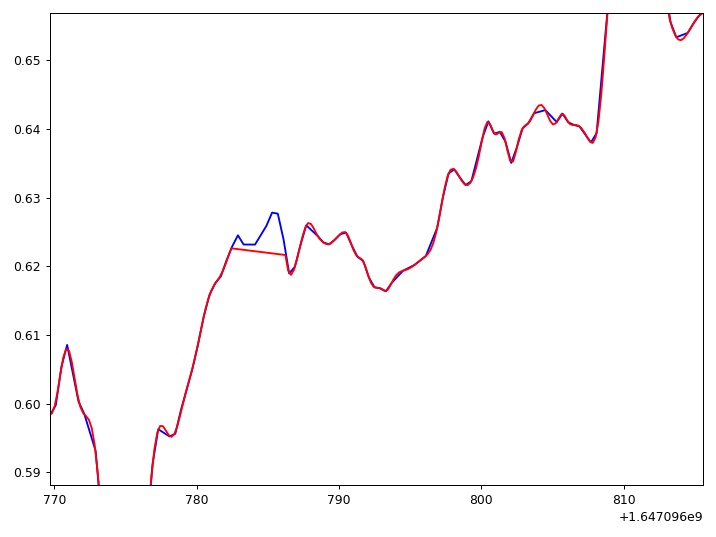

In [33]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.plot(np.array(time_trimble_2), np.array(trimble_2)[2,:], color='b')
ax.plot(np.array(P2)[:,0], np.array(P2)[:,3], color='r')
fig.tight_layout()

<IPython.core.display.Javascript object>


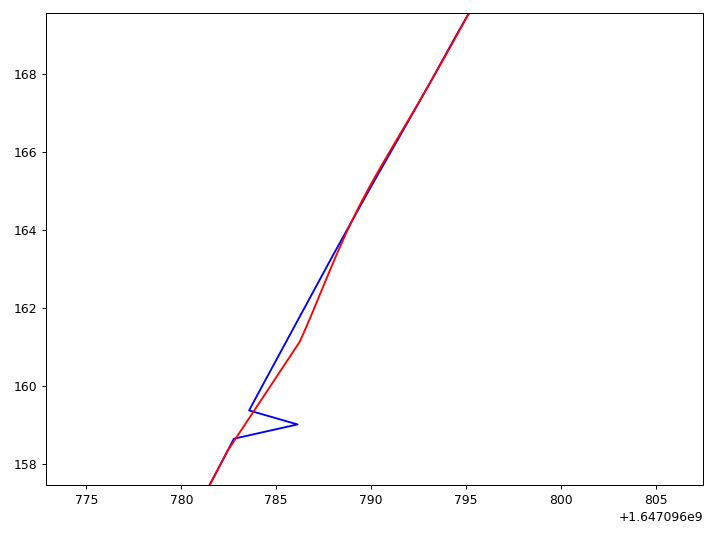

In [35]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.plot(np.array(time_trimble_1), np.array(trimble_1)[0,:], color='b')
ax.plot(np.array(P1)[:,0], np.array(P1)[:,1], color='r')
fig.tight_layout()

<IPython.core.display.Javascript object>


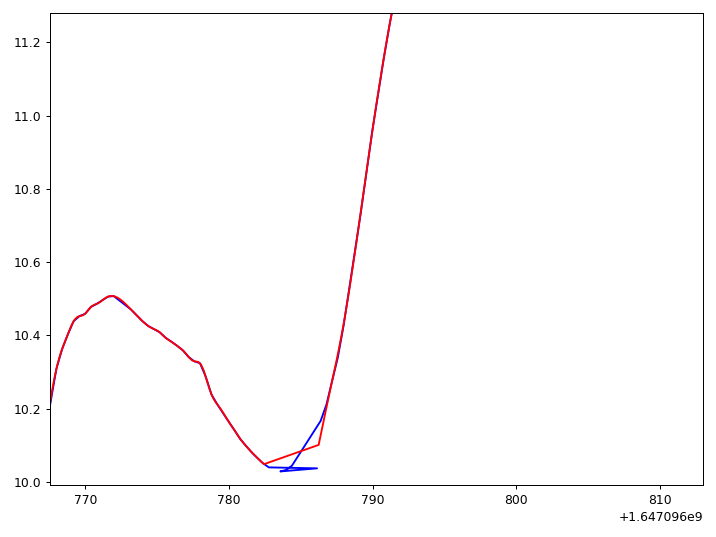

In [36]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.plot(np.array(time_trimble_1), np.array(trimble_1)[1,:], color='b')
ax.plot(np.array(P1)[:,0], np.array(P1)[:,2], color='r')
fig.tight_layout()

<IPython.core.display.Javascript object>


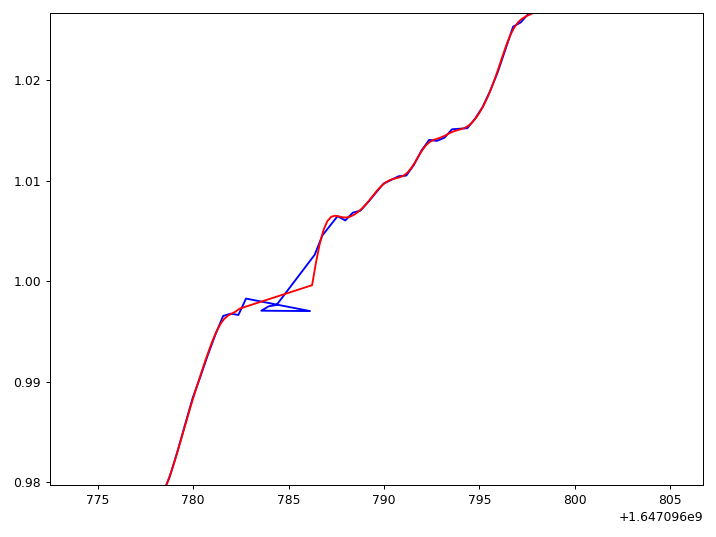

In [37]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.plot(np.array(time_trimble_1), np.array(trimble_1)[2,:], color='b')
ax.plot(np.array(P1)[:,0], np.array(P1)[:,3], color='r')
fig.tight_layout()

<IPython.core.display.Javascript object>


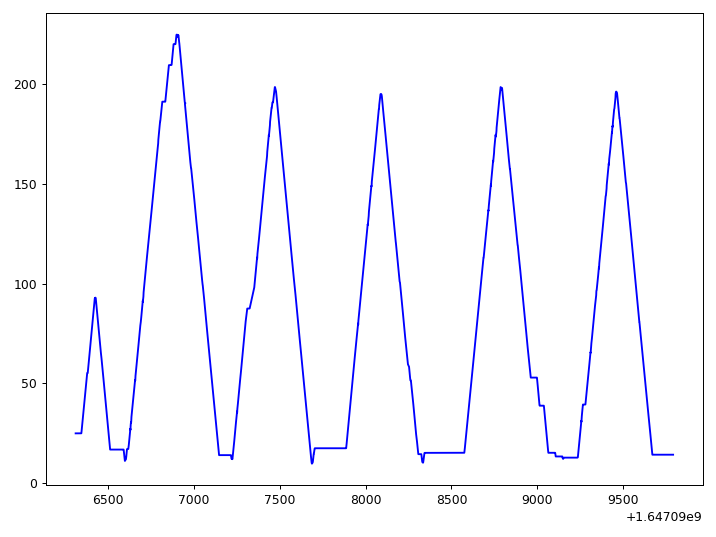

In [41]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.plot(np.array(time_trimble_3), np.array(distance_3), color='b')
fig.tight_layout()

<IPython.core.display.Javascript object>


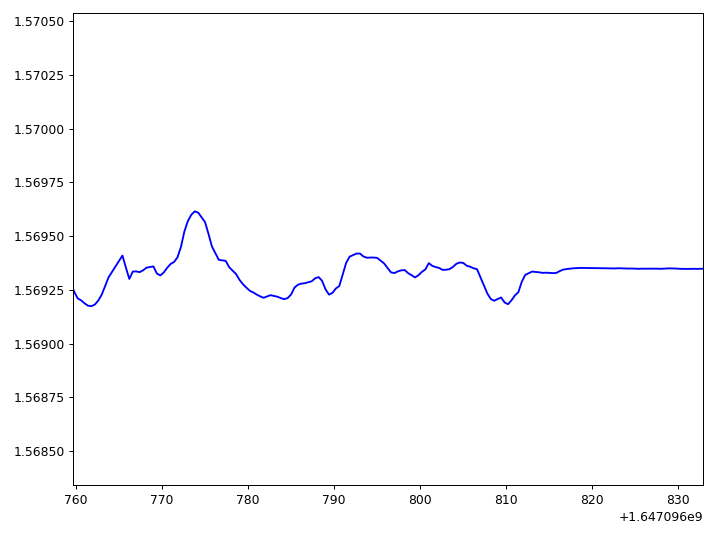

In [39]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.plot(np.array(time_trimble_3), np.array(elevation_3), color='b')
fig.tight_layout()

<IPython.core.display.Javascript object>


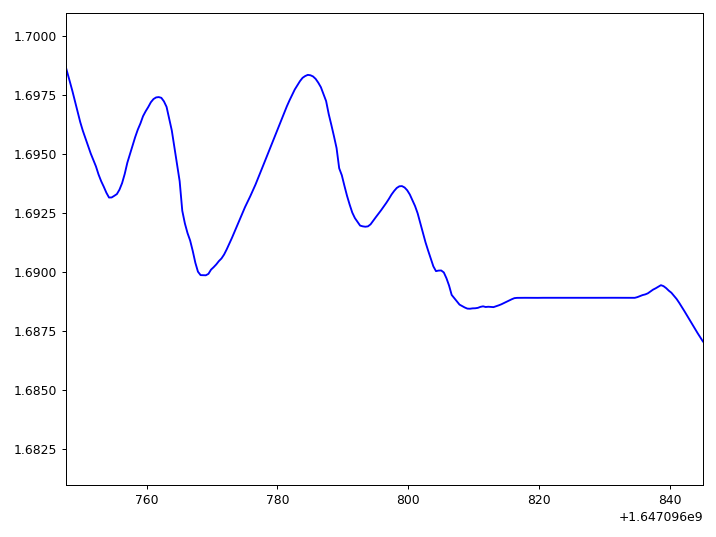

In [40]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.plot(np.array(time_trimble_3), np.array(azimuth_3), color='b')
fig.tight_layout()